In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import importlib
importlib.import_module("utils")
from utils.prepare_dataset import prepare_dataset_fixedsize

In [68]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_GPU = True if torch.cuda.is_available() else "cpu"

In [115]:
max_seq_len = 64
batch_size = 64


geom_train, geom_val, label_train, label_val, gs = prepare_dataset_fixedsize(dataset_size=2000)

train_tokens = torch.tensor(geom_train, dtype=torch.float32)
val_tokens = torch.tensor(geom_val, dtype=torch.float32)
train_labels= torch.tensor(label_train, dtype=torch.long)
val_labels = torch.tensor(label_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(train_tokens, train_labels), batch_size=batch_size, shuffle=True)

In [117]:
class Autoencoder(nn.Module):
    def __init__(self, seq_len, fea_dim, laten_dim):
        super().__init__()
        self.latent_dim = laten_dim
        self.input_size = seq_len * fea_dim
        self.encoder = nn.Sequential(nn.Flatten(),
                                     nn.Linear(self.input_size, laten_dim),
                                     nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(laten_dim, self.input_size))
        self.mse_loss_func = nn.MSELoss()
        self.meta_loss_func = nn.CrossEntropyLoss()
        
    def forward(self, x):
        shape = x.shape
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.contiguous().view(shape)

        coord_output = decoded[:, :, :2]
        meta_output = decoded[:, :, 2:]
        target_meta = torch.argmax(x[:, :, 2:], dim=-1)
        coord_loss = self.mse_loss_func(coord_output, x[:, :, :2])
        # 3 is meta one-hot vocab size
        meta_loss = self.meta_loss_func(meta_output.contiguous().view(-1, 3), target_meta.contiguous().view(-1))

        meta_indices = torch.argmax(meta_output, dim=-1)
        output = torch.cat([coord_output, nn.functional.one_hot(meta_indices, 3)], dim=-1)

        return output, coord_loss*0.25 + meta_loss*0.75
    
    def get_hidden(self, x):
        return self.encoder(x)

        # return decoded, coord_loss

In [118]:
autoencoder = Autoencoder(64, 5, 128)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

num_epoch = 100

for epoch in range(num_epoch):
    autoencoder.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs, loss = autoencoder(inputs)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    train_loss = total_loss/len(train_loader)

    autoencoder.eval()
    with torch.no_grad():
        val_outputs, loss = autoencoder(val_tokens)
        val_loss = loss.item()
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

Epoch 1, Train Loss: 0.48083688735961916, Val Loss: 0.16523849964141846
Epoch 2, Train Loss: 0.107267464697361, Val Loss: 0.0693482905626297
Epoch 3, Train Loss: 0.05505456745624542, Val Loss: 0.046387679874897
Epoch 4, Train Loss: 0.039596774205565455, Val Loss: 0.03673961013555527
Epoch 5, Train Loss: 0.03197073310613632, Val Loss: 0.031662467867136
Epoch 6, Train Loss: 0.02729711003601551, Val Loss: 0.027216648682951927
Epoch 7, Train Loss: 0.023984475061297417, Val Loss: 0.02495974861085415
Epoch 8, Train Loss: 0.02122110053896904, Val Loss: 0.022723320871591568
Epoch 9, Train Loss: 0.01900616254657507, Val Loss: 0.02062828838825226
Epoch 10, Train Loss: 0.017238504961133005, Val Loss: 0.019183754920959473
Epoch 11, Train Loss: 0.015678084343671798, Val Loss: 0.018187595531344414
Epoch 12, Train Loss: 0.014546900056302547, Val Loss: 0.01675906777381897
Epoch 13, Train Loss: 0.013410772494971752, Val Loss: 0.01586424745619297
Epoch 14, Train Loss: 0.01252931173890829, Val Loss: 0.01

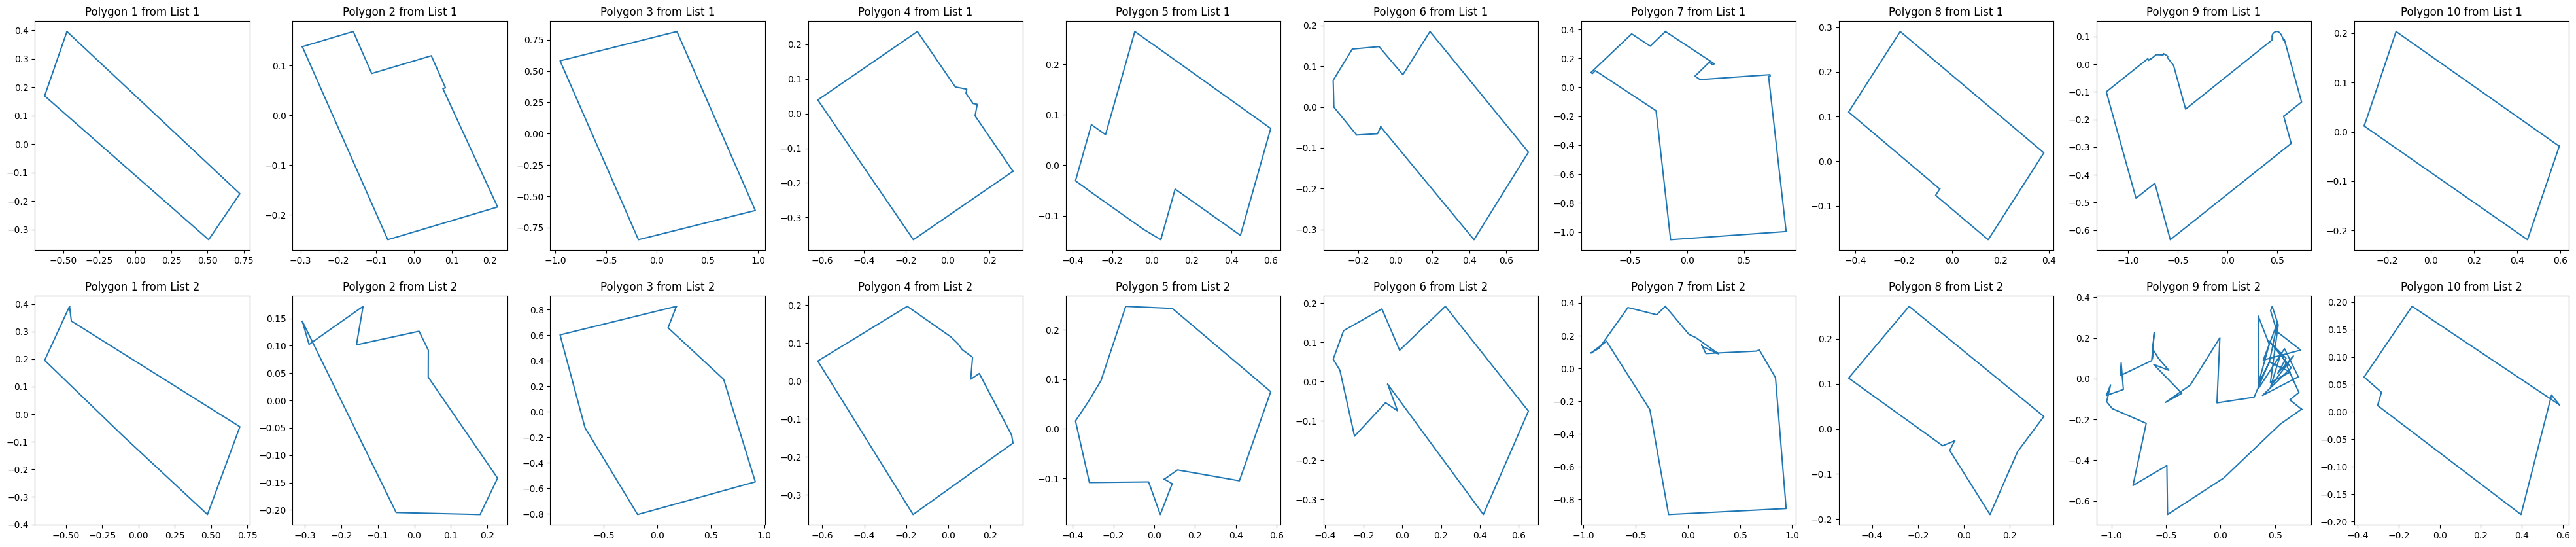

In [119]:
from utils.vector2shape import reverse_vector_polygon
import matplotlib.pyplot as plt

num_samples = 10
ori_polygons = [reverse_vector_polygon(token) for token in val_tokens[10:10+num_samples]]
new_polygons = [reverse_vector_polygon(token) for token in val_outputs[10:10+num_samples]]

# Create a figure with subplots for each polygon
fig, axs = plt.subplots(2, num_samples, figsize=(5*num_samples, 10))

# Plot polygons from the first list
for i, polygon in enumerate(ori_polygons):
    axs[0, i].set_title('Polygon {} from List 1'.format(i+1))
    x, y = polygon.exterior.xy
    axs[0, i].plot(x, y)

# Plot polygons from the second list
for i, polygon in enumerate(new_polygons):
    axs[1, i].set_title('Polygon {} from List 2'.format(i+1))
    x, y = polygon.exterior.xy
    axs[1, i].plot(x, y)

# Show the plot
plt.show()


In [120]:
hidden = autoencoder.get_hidden(val_tokens)
hidden = hidden.detach().numpy()

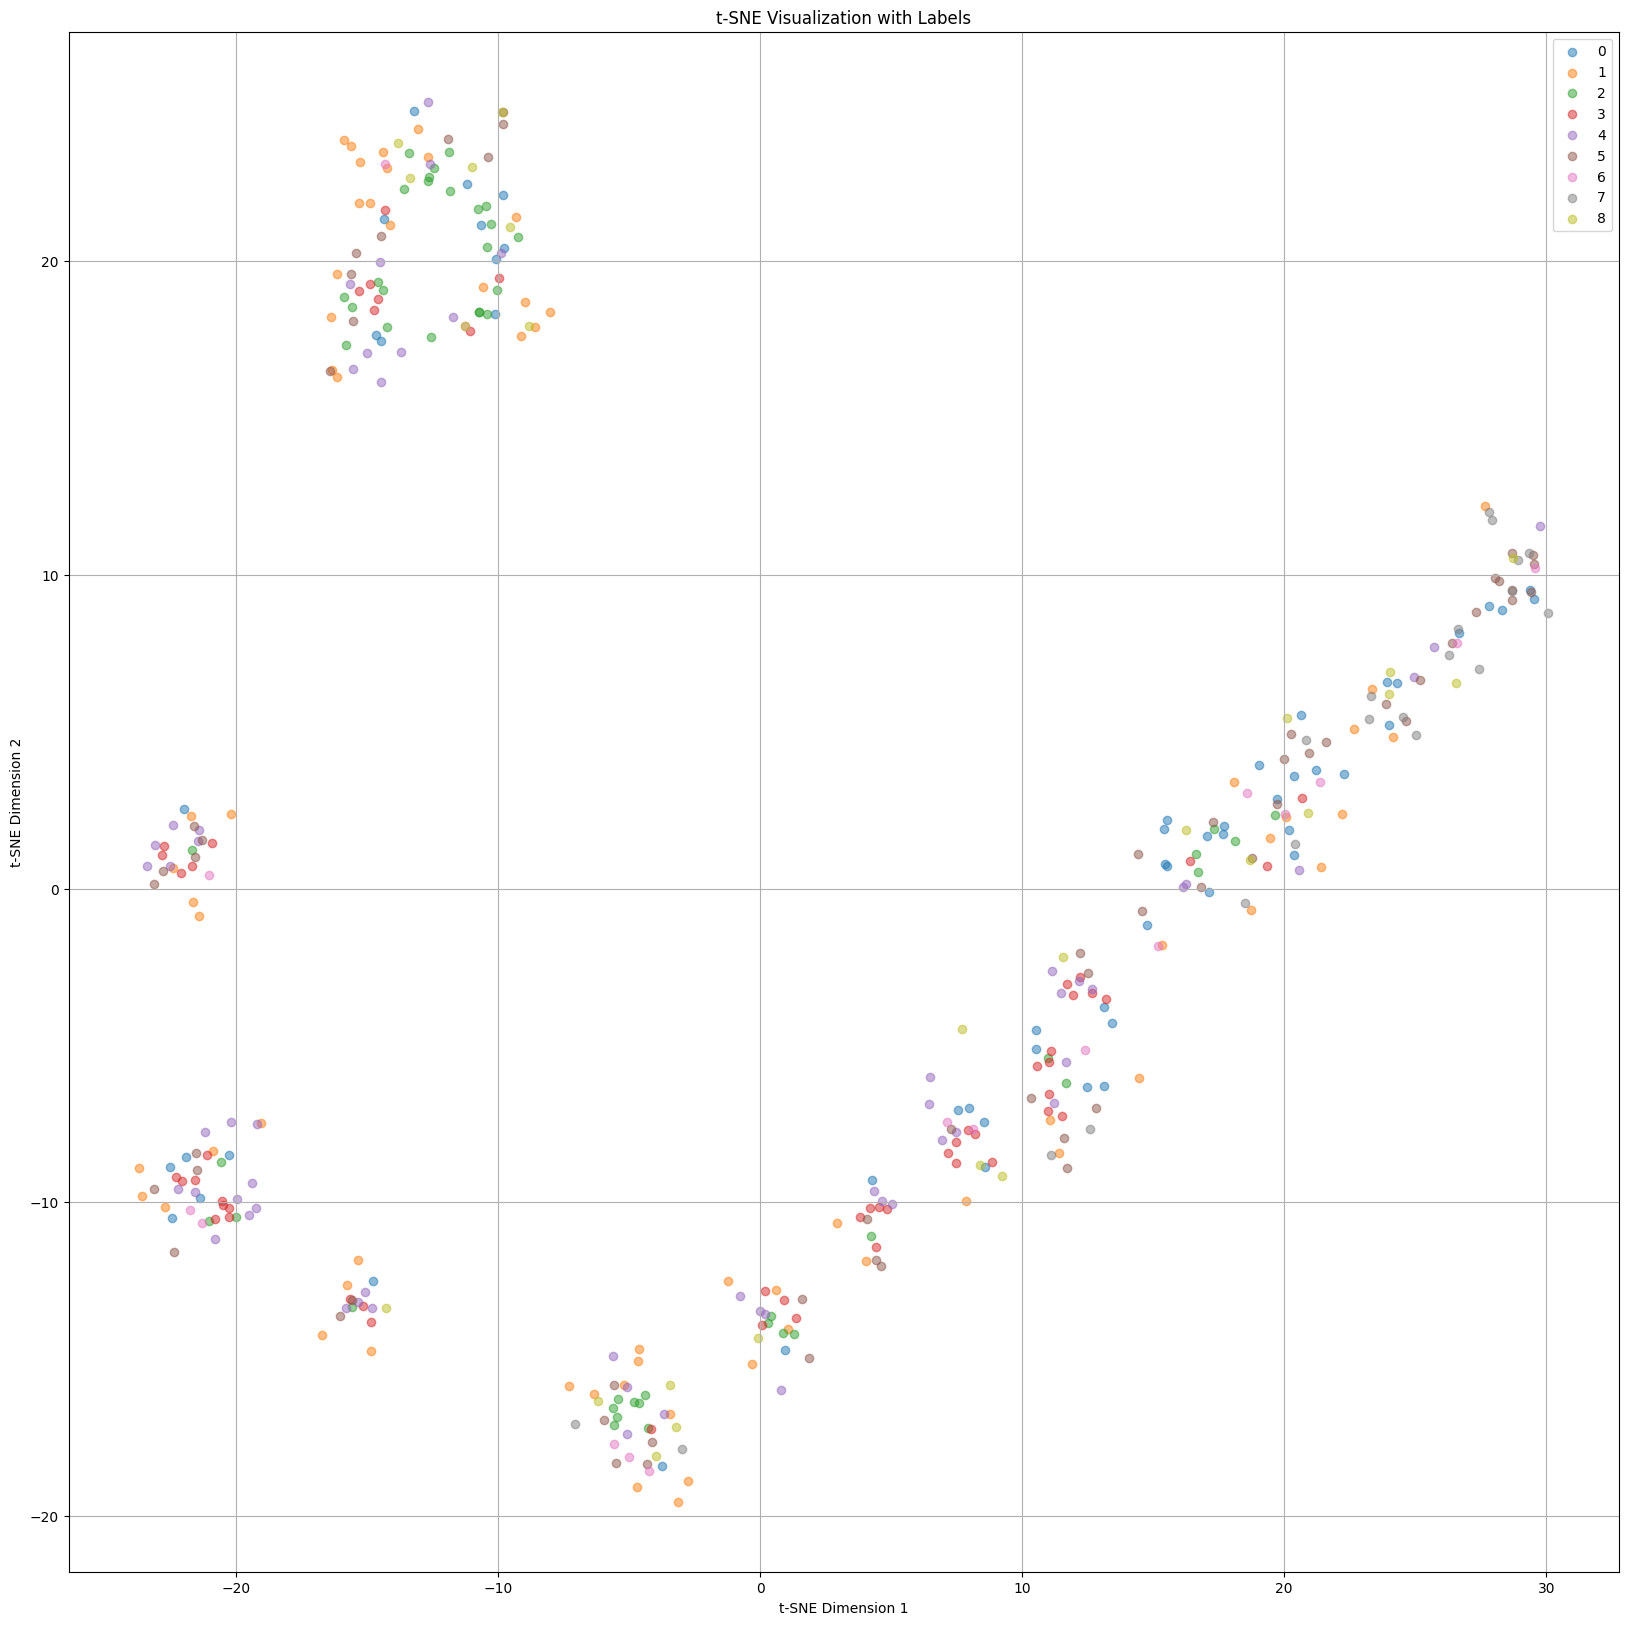

In [121]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np


tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(hidden)

# pca = PCA(n_components=2)
# projections = pca.fit_transform(hidden)

# fig = px.scatter(
#     x=projections[:, 0],
#     y=projections[:, 1],
#     color=test_labels
# )

# fig.show()


plt.figure(figsize=(20, 20))

# Plot each class separately
for label in np.unique(val_labels):
    indices = val_labels == label
    plt.scatter(projections[indices, 0], projections[indices, 1], label=label, alpha=0.5)

plt.title('t-SNE Visualization with Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [128]:
# Define the classifier
class Classifier(nn.Module):
    def __init__(self, input_size, dense_size, num_classes, dropout):
        super().__init__()
        self.dense1 = nn.Linear(input_size, dense_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_size, num_classes)

    def forward(self, x):
        x = self.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        # # Linear probing
        # x = self.dense1(x)
        return x

In [130]:
# with torch.no_grad():
#     train_hidden = autoencoder.get_hidden(train_tokens)
#     val_hidden = autoencoder.get_hidden(val_tokens)

# Without encoding
train_hidden = train_tokens.view(train_tokens.size(0), -1)
val_hidden = val_tokens.view(val_tokens.size(0), -1)

train_loader = DataLoader(TensorDataset(train_hidden, train_labels), batch_size=batch_size, shuffle=True)

In [131]:
classifier = Classifier(train_hidden.size(1), 128, 9, 0.5)

if USE_GPU:
    classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(classifier.parameters(), lr=0.004)
optimizer = optim.Adam(classifier.parameters(), lr=0.004, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)

num_epochs = 100

def train(model, loader):
    model.eval()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_x, batch_y in loader:
        if USE_GPU:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, dim=-1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    train_loss /= len(loader)
    train_acc = correct / total
    return train_loss, train_acc

def evaluate(model, tokens, labels):
    model.eval()
    with torch.no_grad():
        if USE_GPU:
            tokens, labels = tokens.to(device), labels.to(device)
        outputs = model(tokens)
        eval_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, dim=-1)
        eval_acc = (predicted == labels).sum().item() / labels.size(0)
    return eval_loss, eval_acc

for epoch in range(num_epochs):
    train_loss, train_acc = train(classifier, train_loader)
    val_loss, val_acc = evaluate(classifier, val_hidden, val_labels)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss}, Train Acc {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}")


# # Test
# test_loss, test_acc = evaluate(classifier, test_loader)
# print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

Epoch: 1, Train Loss: 2.076648678779602, Train Acc 0.18125, Val Loss: 2.052633285522461, Val Acc: 0.1775
Epoch: 2, Train Loss: 1.9798606872558593, Train Acc 0.22625, Val Loss: 2.048307180404663, Val Acc: 0.2325
Epoch: 3, Train Loss: 1.9509396982192992, Train Acc 0.245, Val Loss: 2.0276169776916504, Val Acc: 0.215
Epoch: 4, Train Loss: 1.9323371648788452, Train Acc 0.251875, Val Loss: 2.0356757640838623, Val Acc: 0.2375
Epoch: 5, Train Loss: 1.899413414001465, Train Acc 0.26125, Val Loss: 2.0635993480682373, Val Acc: 0.2475
Epoch: 6, Train Loss: 1.8663607597351075, Train Acc 0.285, Val Loss: 2.0223515033721924, Val Acc: 0.22
Epoch: 7, Train Loss: 1.830613751411438, Train Acc 0.31, Val Loss: 2.039069414138794, Val Acc: 0.265
Epoch: 8, Train Loss: 1.793381404876709, Train Acc 0.333125, Val Loss: 2.083001136779785, Val Acc: 0.2175
Epoch: 9, Train Loss: 1.7545104265213012, Train Acc 0.355625, Val Loss: 2.0377068519592285, Val Acc: 0.275
Epoch: 10, Train Loss: 1.7255858278274536, Train Acc 0